## SCAO tip tilt map using Zernike covariance

In the following example, we plot the tip/tilt map that we expect from a SCAO configuration, i.e. correcting tip/tilt modes in the field of view with one NGS. \
The sources are elongated ellipses in the NGS's direction. Axes' length and orientation of each ellipse are obtained from tip/tilt covariance matrix computed between the NGS and the considered source.

In [52]:
def computeOffAxisError(covOnOn, covOnOff):
        return 2 * (covOnOn - covOnOff)
    
    
def getOffAxisErrorFromNGS(j_mode, k_mode,
                           distances_from_NGS, ngs_source,
                           ap1, ap2, profile, freqs_vector):
    vk = VonKarmanSpatioTemporalCovariance(source1=ngs_source, source2=ngs_source, aperture1=ap1, aperture2=ap2,
                                           cn2_profile=profile, spat_freqs=freqs_vector)
    ngs_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
    
    residualsList = []
    for coords in distances_from_NGS:
        source = GuideSource(coords, np.inf)
        vk.setSource2(source)
        on_off_covariance = (vk.getZernikeCovariance(j_mode, k_mode).value).real
        res = computeOffAxisError(ngs_covariance, on_off_covariance)
        residualsList.append(res)
    return residualsList


def ellipsePlot(distances_xy, width, height, angle,
                x_max, x_min, y_max, y_min):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    
    mpl.rcParams['figure.dpi'] = 150
    ellipse = [Ellipse((distances_xy[i, 0], distances_xy[i, 1]),
                       width[i], height[i], angle=angle[i]) for i in range(len(width))]
    fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
    for e in ellipse:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        
def getCartesianPositions(rho, theta):
    x = rho * np.cos(np.deg2rad(theta))
    y = rho * np.sin(np.deg2rad(theta))
    return x, y


def computeEllipseParameters(tip_tip_res, tilt_tilt_res, tip_tilt_res):
    covariance_matrix = np.array([[tip_tip_res, tip_tilt_res], [tip_tilt_res, tilt_tilt_res]])
    eig_values, eig_vectors = np.linalg.eigh(covariance_matrix)
    order = eig_values.argsort()[::-1]
    val_sort, vect_sort = eig_values[order], eig_vectors[:, order]
    theta = np.rad2deg(np.arctan2(vect_sort[:, 0][1], vect_sort[:, 0][0]))
    width, height = 2 * np.sqrt(val_sort)
    return width, height, theta

In [53]:
import numpy as np
from apposto.types.guide_source import GuideSource
from apposto.types.aperture import CircularOpticalAperture
from apposto.atmo.cn2_profile import Cn2Profile
from apposto.atmo.von_karman_covariance_calculator import VonKarmanSpatioTemporalCovariance

#Initialization of NGS's position, apertures' positions, turbulence profile and spatial frequencies array.
ngs = GuideSource((0, 0), np.inf)
aperture1 = CircularOpticalAperture(5, [0, 0, 0])
aperture2 = CircularOpticalAperture(5, [0, 0, 0])
cn2_profile = Cn2Profile.from_r0s([0.16], [25], [10e3], [10], [-20])
spatial_freqs = np.logspace(-3, 3, 100)

#Definition of off-axis stars' positions.
rhos = np.random.randint(-50, 50, size=(500))
thetas = np.random.randint(360, size=(500))
positionsInPolar = np.stack((rhos, thetas), axis=-1)

#Computation of tip/tilt residuals.
res22 = getOffAxisErrorFromNGS(j_mode=2, k_mode=2, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res33 = getOffAxisErrorFromNGS(j_mode=3, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)
res23 = getOffAxisErrorFromNGS(j_mode=2, k_mode=3, distances_from_NGS=positionsInPolar,
                                  ngs_source=ngs, ap1=aperture1, ap2=aperture2, profile=cn2_profile,
                                  freqs_vector=spatial_freqs)

Text(0, 0.5, 'arcsec')

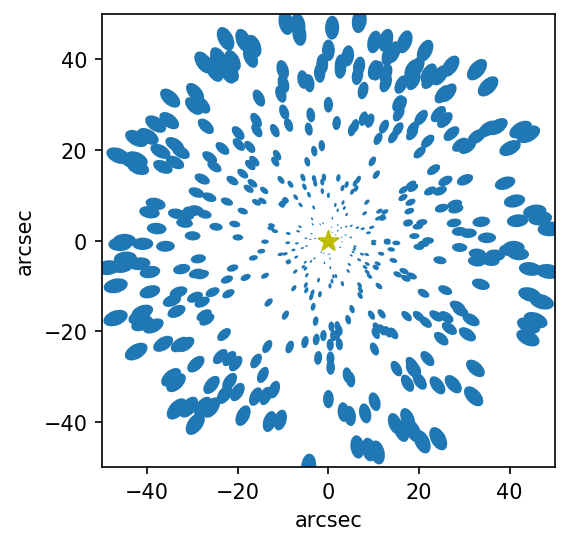

In [54]:
#Computation of covariance ellipses' parameters.
positionsInXY = np.stack(getCartesianPositions(rhos, thetas), axis=-1)
widths = []
heights = []
ths = []
for i in range(len(res22)):
    w, h, t = computeEllipseParameters(res22[i], res33[i], res23[i])
    widths.append(w/2)
    heights.append(h/2)
    ths.append(t)

#Plot of the tip tilt map (field in XY coordinates).
import matplotlib.pyplot as plt
ellipsePlot(distances_xy=positionsInXY, width=widths, height=heights, angle=ths,
            x_max=50, x_min=-50, y_max=50, y_min=-50)

plt.scatter(0, 0, marker='*', s=100, color='y')
plt.xlabel('arcsec')
plt.ylabel('arcsec')